In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
import gensim.downloader as api
import re
import string
from collections import Counter
from torch.utils.data import Dataset

from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim import Adam
from torch.optim import Optimizer
import random

/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv
/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv


let's look at our data

In [2]:
df_train = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')

In [3]:
df_train

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg
...,...,...
24995,"This film is fun, if your a person who likes a...",pos
24996,After seeing this film I feel like I know just...,pos
24997,first this deserves about 5 stars due to actin...,neg
24998,If you like films that ramble with little plot...,neg


In [4]:
df_test = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')

In [5]:
df_test

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos
...,...,...
24995,"For one thing, he produced this movie. It has ...",neg
24996,The title comes from an alteration an adolesce...,pos
24997,Christopher Nolan's first film is a 'no budget...,pos
24998,The story is shortly about the faith-lacking b...,neg


How can we notice that we have the same amount of data for training and testing. For analysis we have the review itself and its classification
- 'pos' -positive
- 'neg'- negative

In [6]:
#let's work with fasttext
fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [7]:
fasttext.most_similar(positive=['man'])

[('was', 0.9065622091293335),
 ('i', 0.8880172371864319),
 ('he', 0.887438178062439),
 ('bad', 0.8846145272254944),
 ('even', 0.8832389712333679),
 ('be', 0.8784030079841614),
 ('we', 0.8764979243278503),
 ('not', 0.8764553666114807),
 ('had', 0.8762108683586121),
 ('glad', 0.8758711218833923)]

In [8]:
fasttext.most_similar(positive=['king', 'woman'], negative=['man'])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

Let's write a class to process our reviews

In [9]:
class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self.vocabulary.append('<pad>')

        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()

        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def get_pad(self):
        return self.word2idx('<pad>')

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [10]:
class IMDB(Dataset):
    def __init__(self, df, vocab):
        self.df = df

        self.vocab = vocab

        self.label2idx = {
            'pos': 0,
            'neg': 1
        }

    def __getitem__(self, idx):
        text = self.df['text'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

let's create a model

In [11]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=1,
                    out_channels=32,
                    kernel_size=(fs, embedding_dim))
                for fs in [2, 3, 4, 5, 6]
            ]
        )

        self.fc = nn.Linear(5 * 32, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim=1))

        return self.fc(x)

In [12]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device
):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y).item()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    return train_loss, train_accuracy

In [13]:
@torch.inference_mode()
def evaluate(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn,
        device: torch.device
):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y).item()

    total_loss /= len(data_loader)
    total_accuracy /= len(data_loader)

    return total_loss, total_accuracy

In [14]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [15]:
def whole_train_valid_cycle(
        model,
        train_loader,
        valid_loader,
        optimizer,
        loss_fn,
        device,
        threshold,
        title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break

In [16]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()

    prediction = []

    for x, _ in loader:
        output = model(x.to(device)).cpu()

        prediction.append(torch.round(torch.sigmoid(output)))

    prediction = torch.cat(prediction).ravel()

    return prediction

In [17]:
def main(threshold, title):
    set_seed(0xDEADF00D)

    #load data
    df_train = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')
    df_test = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    df = pd.concat([df_train, df_test])
    
    #create vocabulary
    vocab = Vocabulary(df['text'].values, min_freq=5)

    train_dataset = IMDB(df_train, vocab)
    test_dataset = IMDB(df_test, vocab)

    pad_idx = vocab.get_pad()

    def collate_fn(batch):
        texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
        labels = torch.stack([b[1] for b in batch])

        return texts, labels

    train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

    vectors = vocab.build_vectors(api.load('glove-twitter-25'))

    model = TextCNN(vocab_size=len(vocab.vocabulary), embedding_dim=25, pad_idx=pad_idx)

    model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=1e-3)

    loss_fn = nn.BCEWithLogitsLoss()

    whole_train_valid_cycle(model, train_loader, test_loader, optimizer, loss_fn, device, threshold, title)

    torch.save(predict(model, test_loader, device), 'prediction.pt')

**Let's achieve 85% quality on the test sample!**

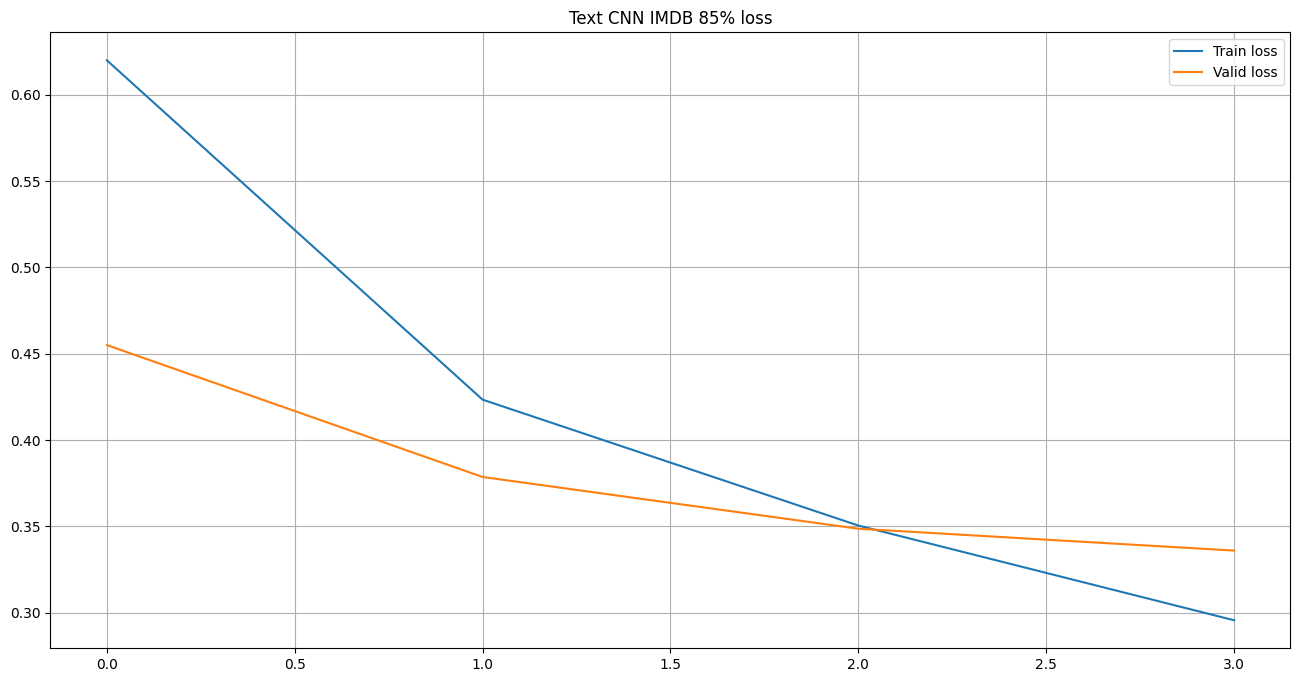

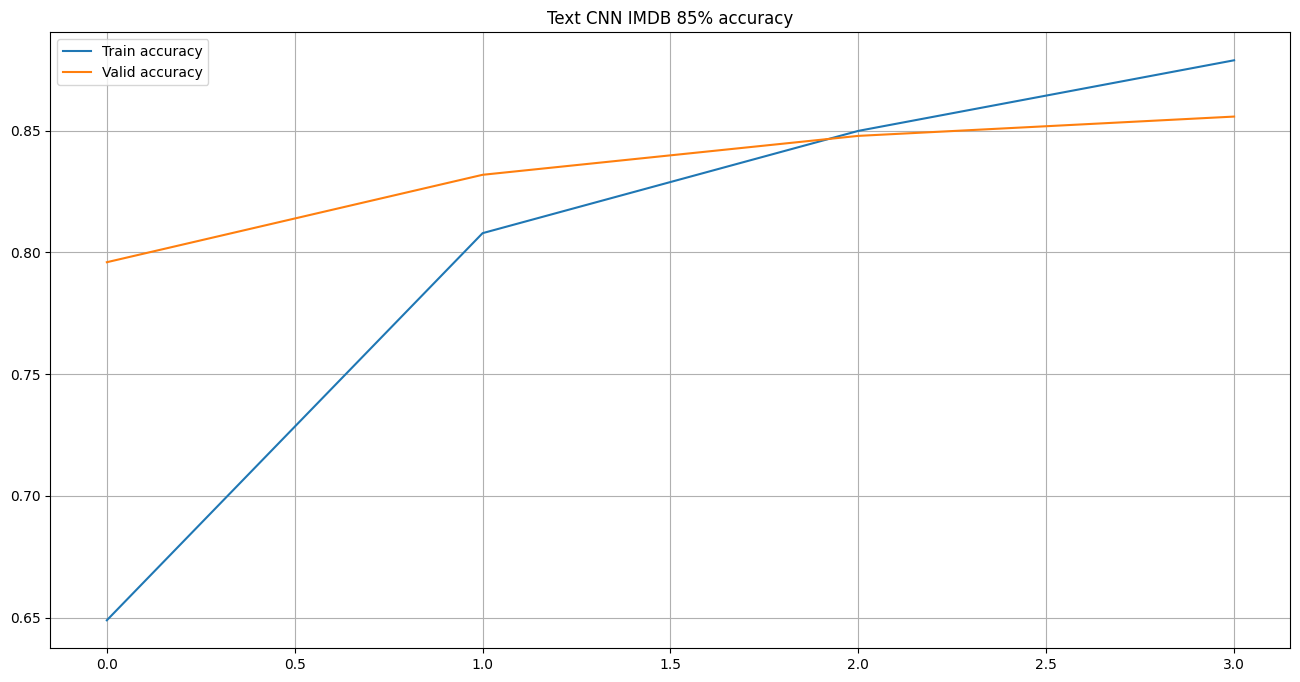

In [18]:
main(0.85, 'Text CNN IMDB 85%')